In [1]:
import sys

import tensorflow as tf
import pandas as pd
import numpy as np

import yaml

sys.path.append("/home/thomas/projects/nilm_at_fair/repository")
from src.pulsed_power_ml.model_framework.data_io import read_training_files
from src.pulsed_power_ml.model_framework.visualizations import plot_data_point_array
from src.pulsed_power_ml.model_framework.visualizations import plot_state_vector_array

from src.pulsed_power_ml.models.gupta_model.tf_gupta_clf import TFGuptaClassifier

from src.pulsed_power_ml.models.gupta_model.gupta_clf import GuptaClassifier

print(sys.executable)

2022-12-08 18:30:58.939203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 18:30:59.023849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 18:30:59.023864: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 18:30:59.464037: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

/home/thomas/.venv/py10_kitchensink/bin/python3.10


2022-12-08 18:31:00.361570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 18:31:00.361774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 18:31:00.361815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-08 18:31:00.361850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-08 18:31:00.363328: W tensorflow/c

# Load training and validation data

In [2]:
# Load training data
training_data_folder = "/home/thomas/projects/nilm_at_fair/training_data/2022-11-16_features_labels/"
features_file = f"{training_data_folder}/Features_ApparentPower.csv"
labels_file = f"{training_data_folder}/Labels_ApparentPower.csv"

features = tf.constant(value=pd.read_csv(features_file).values, dtype=tf.float32)
labels = tf.constant(value=pd.read_csv(labels_file).values, dtype=tf.float32)

In [3]:
# load apparent power list
apparent_power_data_base = "/home/thomas/projects/nilm_at_fair/repository/src/pulsed_power_ml/models/gupta_model/apparent_power_data_base.yml"

with open(apparent_power_data_base) as yaml_file:
    apparent_power_dict = yaml.load(yaml_file, Loader=yaml.loader.SafeLoader)

appliance_names = apparent_power_dict.keys()

apparent_power_list = tf.constant(
    value=list(apparent_power_dict.values()),
    dtype=tf.float32
)

In [4]:
# Load some GNU Radio data for simulated "live data"
gr_data_folder = "/home/thomas/projects/nilm_at_fair/training_data/2022-11-16_training_data/r1"
data_point_array = read_training_files(path_to_folder=gr_data_folder,
                                       fft_size=2**17)

# Instantiate TensorFlow Model

In [5]:
tf_model = TFGuptaClassifier(
    background_n=tf.constant(1, dtype=tf.int32),
    n_known_appliances=tf.constant(11, dtype=tf.int32),
    n_peaks_max=tf.constant(10, dtype=tf.int32),
    apparent_power_list=apparent_power_list,
    n_neighbors=tf.constant(3, dtype=tf.int32),
    training_data_features=features,
    training_data_labels=labels
)

In [6]:
state_vector_list = list()
for data_point in data_point_array:
    state_vector = tf_model(tf.constant(data_point, dtype=tf.float32))
    state_vector_list.append(state_vector)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


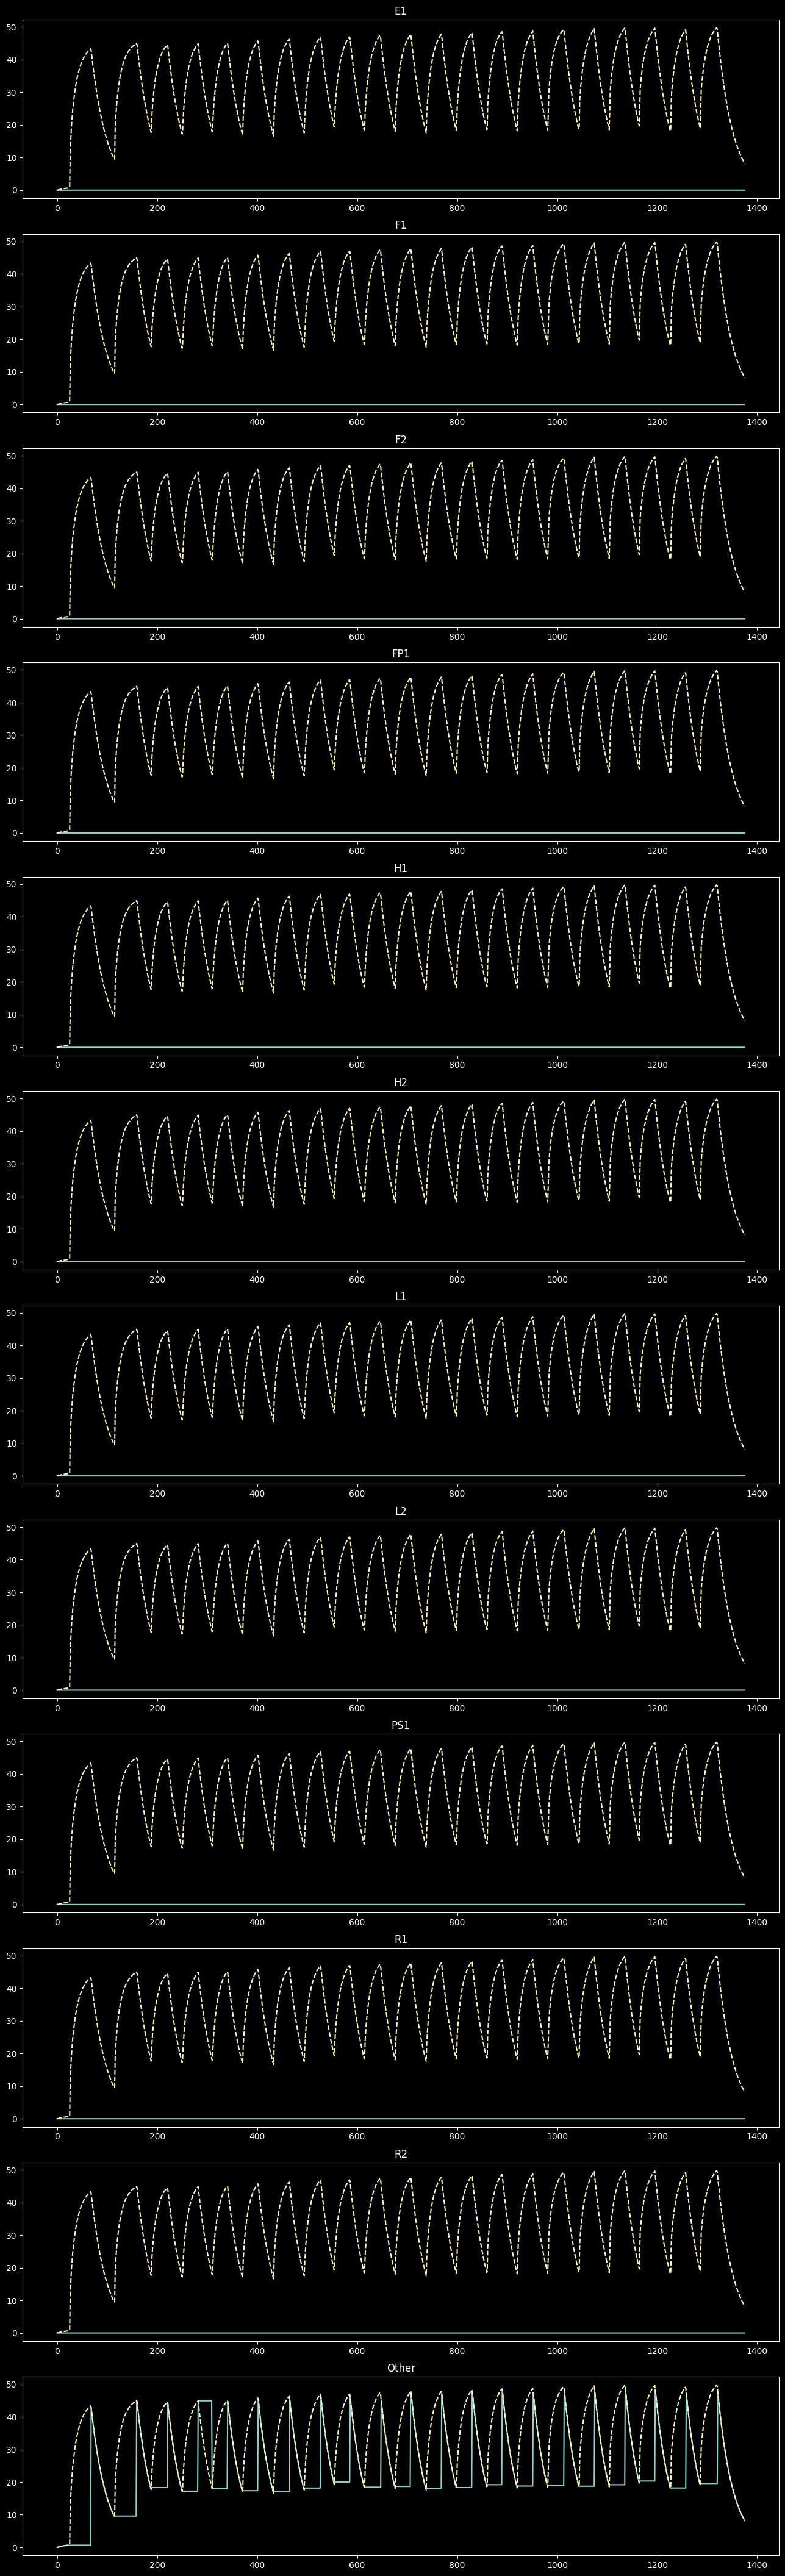

In [7]:
fig = plot_state_vector_array(state_vector_list=np.array(state_vector_list),
                              label_list=list(appliance_names),
                              true_apparent_power=data_point_array[:,-2])
fig.savefig=("/home/thomas/projects/nilm_at_fair/training_data/model_validation/tf_model_r1_alt_plot.pdf")

In [8]:
np.array(state_vector_list).shape[1]

12

In [9]:
# fig = plot_data_point_array(data_point_array,
#                             2**17,
#                             state_vector_list)
# fig.savefig("/home/thomas/projects/nilm_at_fair/training_data/model_validation/tf_model_fp1_no_spectra.pdf")

# Instantiate Python model

In [15]:
py_app_power_list = list()
for app_power in apparent_power_list:
    py_app_power_list.append(("app_name", app_power))

py_model = GuptaClassifier(
    background_n=5,
    spectrum_type=2,
    apparent_power_list=py_app_power_list,
    n_neighbors=3,
    distance_threshold=100
)

In [16]:
py_model.fit(features,
             labels)

GuptaClassifier(apparent_power_list=[('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=4.8>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=480.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=490.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=24.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=42.0>),
                                     ('app_name',
                                      <tf.T...
                                      <tf.Tensor: shape=(), dtype=float32, numpy=27.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=33.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=50.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=50.0>),
                                     ('app_name',
                                      <tf.Tensor: shape=(), dtype=float32, numpy=50.0>)],
                background_n=5, distance_threshold=100, n_neighbors=3,
                spectrum_type=2)

In [ ]:
state_vector_list_py = list()
for data_point in data_point_array:
    state_vector = py_model.predict(data_point)
    state_vector_list_py.append(state_vector)

In [18]:
# fig = plot_data_point_array(data_point_array,
#                             2**17,
#                             state_vector_list_py)
# fig.savefig("/home/thomas/projects/nilm_at_fair/training_data/model_validation/py_model_fp1_no_spectra.pdf")

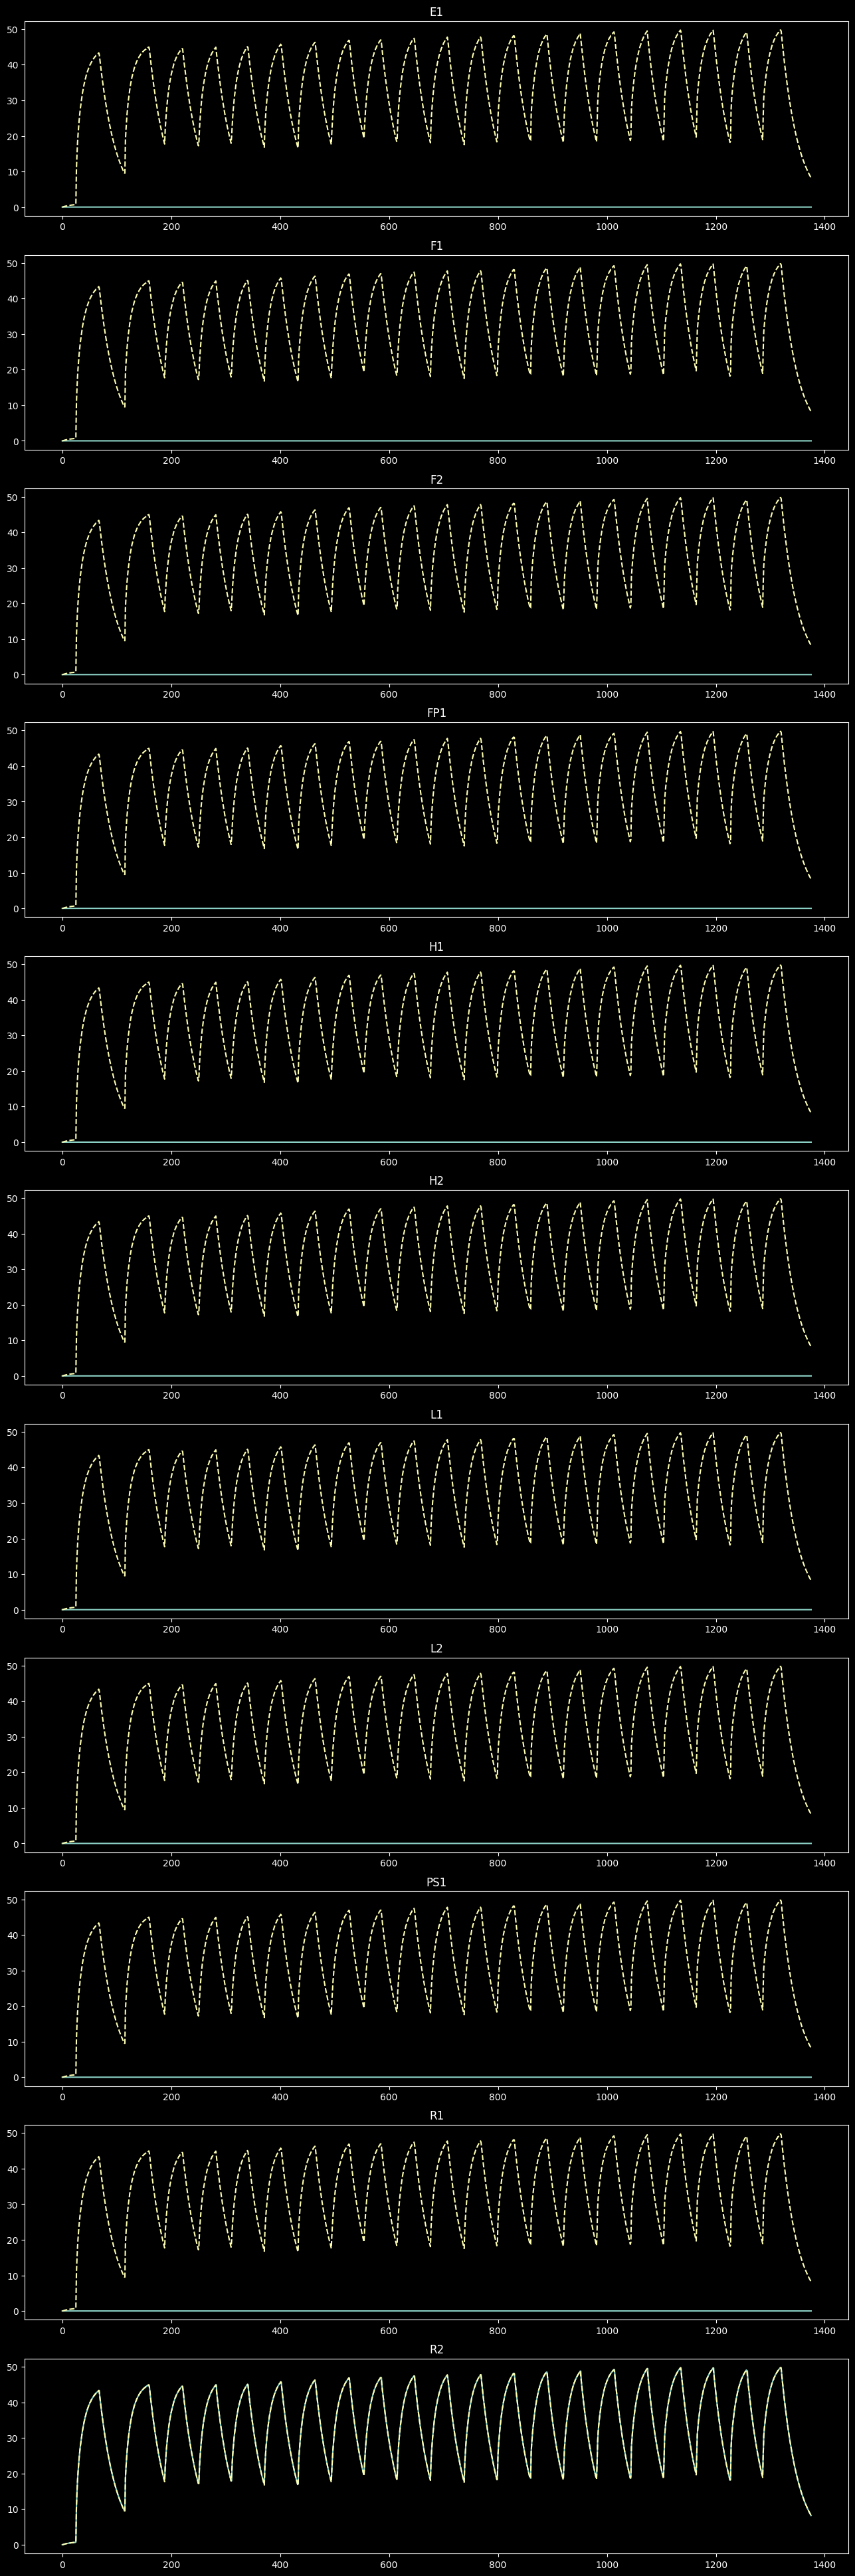

In [20]:
fig = plot_state_vector_array(state_vector_list=np.array(state_vector_list_py),
                              label_list=list(appliance_names),
                              true_apparent_power=data_point_array[:,-2])
fig.savefig=("/home/thomas/projects/nilm_at_fair/training_data/model_validation/py_model_r1_alt_plot.pdf")